In [21]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import time

import block_update
import bouguer
import prisms
import rfgen
import utilities

import importlib
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(rfgen)
importlib.reload(prisms)
importlib.reload(utilities)

from block_update import *
from bouguer import *
from rfgen import *
from prisms import *
from utilities import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import geopandas as gpd
from pyproj import CRS, Transformer
from tqdm.auto import tqdm
from scipy.spatial import cKDTree

In [2]:
#BedMachine Import

In [3]:
bm = xr.open_dataset('BedMachineAntarctica-v3.nc')

In [4]:
#BedMachine Trimming

In [5]:
# Defines bounding box coordinates
x_min = -1700000
x_max = -1100000
y_min = -1200000
y_max = -700000

# Checks the original data's bounds
print("Original x range:", bm['x'].min().values, bm['x'].max().values)
print("Original y range:", bm['y'].min().values, bm['y'].max().values)

# Creates masks for x and y coordinates
x_mask = (bm['x'] >= x_min) & (bm['x'] <= x_max)
y_mask = (bm['y'] >= y_min) & (bm['y'] <= y_max)

# Applies masks to select the data within the bounds
trimmed_data = bm.where(x_mask & y_mask, drop=True)

# Checks if the trimmed data has any points
if trimmed_data['x'].size == 0 or trimmed_data['y'].size == 0:
    print("No data found in the selected region.")
else:
    print("Data is available in the selected region.")

# Additional check to ensure y values are not empty and have valid ranges
if trimmed_data['y'].size > 0:
    print(f"Trimmed y range: {trimmed_data['y'].min().values} to {trimmed_data['y'].max().values}")
else:
    print("No valid y values found in the trimmed data.")

Original x range: -3333000 3333000
Original y range: -3333000 3333000
Data is available in the selected region.
Trimmed y range: -1200000 to -700000


In [6]:
#BedMachine Coarsening

In [7]:
from scipy.stats import mode

def mode_custom(a):
    vals = mode(a)
    return vals[0].squeeze()

In [8]:
# Defines the coarsening factor
# Original resolution: 500 m, target resolution: 5 km (5000 m)
coarsening_factor = 5000 // 500  # 10x10 grid cells

# Defines mode function for categorical data with axis handling
def mode_custom(array, axis):
    vals, _ = mode(array, axis=axis, nan_policy='omit')  # Handle NaNs if present
    return vals

# Coarsens continuous variables using mean reduction
continuous_vars = ['bed', 'surface', 'thickness']  # Adjust based on your dataset variables
coarsened_continuous = trimmed_data[continuous_vars].coarsen(x=coarsening_factor, y=coarsening_factor, boundary='trim').mean()

# Coarsens categorical variables using mode reduction
categorical_vars = ['mask']  # Adjust based on your dataset variables
coarsened_categorical = {}

for var in categorical_vars:
    coarsened_categorical[var] = trimmed_data[var].coarsen(x=coarsening_factor, y=coarsening_factor, boundary='trim').reduce(mode_custom)

# Combines coarsened data into a new dataset
coarsened_dataset = coarsened_continuous.assign(**coarsened_categorical)

# make sure surface is 0 in open water
coarsened_dataset['surface'] = (('y', 'x'), np.where(coarsened_dataset.mask==0, 0, coarsened_dataset.surface))

# make sure thickness is 0 in open water and at exposed rock
ocean_rock_msk = (coarsened_dataset.mask==0)^(coarsened_dataset.mask==1)
coarsened_dataset['thickness'] = (('y', 'x'), np.where(ocean_rock_msk, 0, coarsened_dataset.thickness))

# make sure bed is equal to surface minus thickness under grounded ice
coarsened_dataset['bed'] = (('y', 'x'), np.where(coarsened_dataset.mask==2, coarsened_dataset.surface-coarsened_dataset.thickness, coarsened_dataset.bed))

# make sure surface is equal to bed at exposed rock
coarsened_dataset['bed'] = (('y', 'x'), np.where(coarsened_dataset.mask==1, coarsened_dataset.surface, coarsened_dataset.bed))

# make sure bed not above ice in ice shelf
bed_above_ice_bottom = np.where(coarsened_dataset.bed > (coarsened_dataset.surface-coarsened_dataset.thickness), True, False)
coarsened_dataset['bed'] = (('y', 'x'), np.where(bed_above_ice_bottom, coarsened_dataset.surface-coarsened_dataset.thickness, coarsened_dataset.bed))

# make mask grounded ice where bed was above ice bottom
coarsened_dataset['mask'] = (('y', 'x'), np.where(bed_above_ice_bottom, 2, coarsened_dataset.mask))

# Prints new grid spacing
new_x_spacing = (trimmed_data['x'].diff('x').mean() * coarsening_factor).values
new_y_spacing = (trimmed_data['y'].diff('y').mean() * coarsening_factor).values
print(f"New grid spacing: {new_x_spacing:.0f} m (X), {new_y_spacing:.0f} m (Y)")

# Outputs the coarsened dataset (optional, just to inspect)
print(coarsened_dataset)

New grid spacing: 5000 m (X), -5000 m (Y)
<xarray.Dataset> Size: 242kB
Dimensions:    (y: 100, x: 120)
Coordinates:
  * x          (x) float64 960B -1.698e+06 -1.693e+06 ... -1.108e+06 -1.103e+06
  * y          (y) float64 800B -7.022e+05 -7.072e+05 ... -1.192e+06 -1.197e+06
Data variables:
    bed        (y, x) float32 48kB -461.7 -470.8 -479.3 ... -657.6 -552.2 -237.2
    surface    (y, x) float32 48kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 44.66 54.78 41.26
    thickness  (y, x) float32 48kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 483.6 512.4 267.1
    mask       (y, x) float64 96kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 3.0 3.0 3.0
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spac

In [9]:
#Gravity Data Import

Looking for folder: /Users/holden/Desktop/Ice Shits/cryo_share copy/OIB_Sander
OIB Sander folder found!


  0%|          | 0/155 [00:00<?, ?it/s]

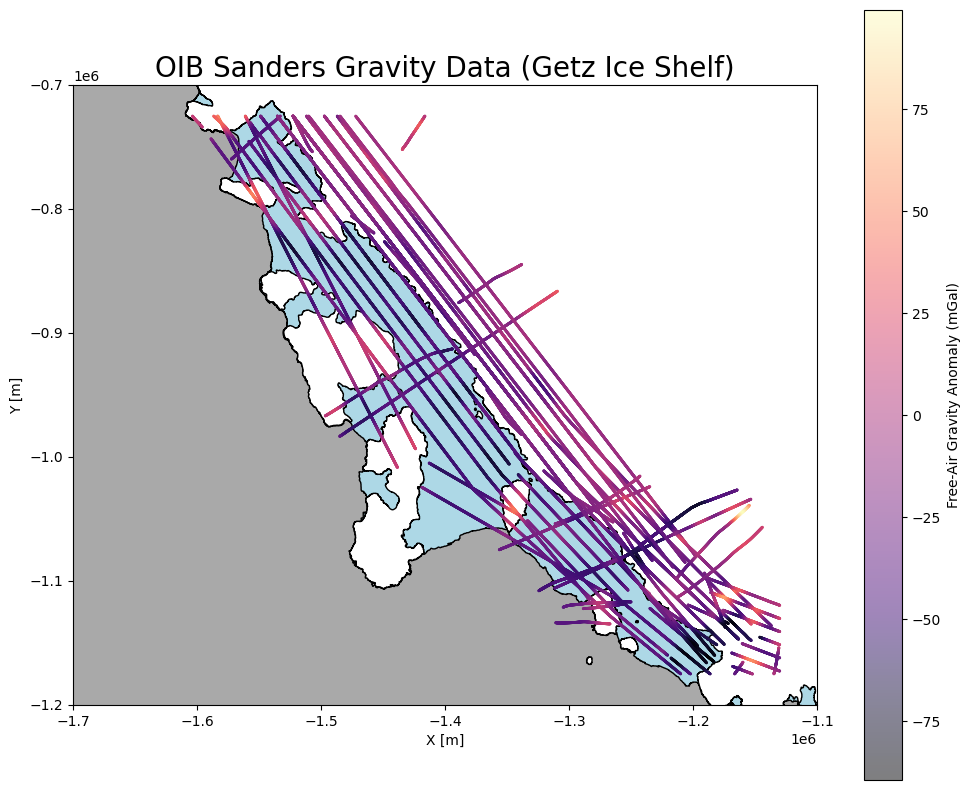

In [12]:
# Path stuff

# Corrected path
data_folder = Path("/Users/holden/Desktop/Ice Shits/cryo_share copy/OIB_Sander")
print(f"Looking for folder: {data_folder.resolve()}")

# Checks if the folder exists
if data_folder.exists():
    print("OIB Sander folder found!")
else:
    print("OIB Sander folder not found.")


# OIB Sander

# gets number of OIB folders for tqdm
num_folders = 0
for folder in os.scandir('/Users/holden/Desktop/Ice Shits/cryo_share copy/OIB_Sander'):
    num_folders += 1

# iterates through folders and ingest data
tables = []
for folder in tqdm(os.scandir('/Users/holden/Desktop/Ice Shits/cryo_share copy/OIB_Sander'), total=num_folders):
    for item in os.scandir(folder.path):
        if item.name.endswith('.txt'):
            tmp = pd.read_table(item.path, header=69, sep='\s+')
            header = tmp.columns[1:]
            tmp = tmp.drop(columns=['FLTENVIRO'])
            tmp.columns = header
            tables.append(tmp)

oib = pd.concat(tables, axis=0)
oib

oib = oib[['LAT', 'LONG', 'PSX', 'PSY', 'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO', 'WGSHGT']]
oib.columns = ['lat', 'lon', 'x', 'y', 'faa70', 'faa100', 'faa140', 'flag', 'height']
oib = oib[oib.flag == 0]
oib = oib.drop(columns=['flag']).reset_index(drop=True)
oib

# Path to the "moa" folder
moa_path = Path("/Users/holden/Desktop/Ice Shits/cryo_share copy/moa")

# Loads the shapefiles from the correct path
moa_coast = gpd.read_file(moa_path / "coastlines/moa2014_coastline_v01.shp")
moa_gl = gpd.read_file(moa_path / "coastlines/moa2014_grounding_line_v01.shp")
moa_islands = gpd.read_file(moa_path / "coastlines/moa2014_islands_v01.shp")

padding_percent = 0.05

# Calculate padding for the x and y ranges
x_padding = (x_max - x_min) * padding_percent
y_padding = (y_max - y_min) * padding_percent

# Adjust the bounds for the gravity data (add padding)
x_min_padded = x_min + x_padding
x_max_padded = x_max - x_padding
y_min_padded = y_min + y_padding
y_max_padded = y_max - y_padding


# Filters OIB Sanders within the padded bounds
oib_trimmed = oib[(oib['x'] >= x_min_padded) & (oib['x'] <= x_max_padded) & (oib['y'] >= y_min_padded) & (oib['y'] <= y_max_padded)]

# Combines the trimmed datasets, including 'x', 'y', 'faa', and 'height'
# Ensures that 'height' is carried over from both datasets
gravity_trimmed = oib_trimmed

# Plots the data as scatter
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_facecolor('darkgray')

# Plots the MOA background data
moa_coast.plot(facecolor='lightblue', edgecolor='k', ax=ax)
moa_gl.plot(facecolor='white', edgecolor='k', ax=ax)
moa_islands.plot(facecolor='white', edgecolor='k', ax=ax)

# Scatters plot of OIB gravity data, only within the bounds of Getz Ice Shelf
sc = ax.scatter(gravity_trimmed['x'], gravity_trimmed['y'], c=gravity_trimmed['faa140'], s=1, cmap='magma', alpha=0.5)

# Sets the x and y limits to the specified bounds for the Getz Ice Shelf
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# Adds a colorbar
plt.colorbar(sc, ax=ax, label='Free-Air Gravity Anomaly (mGal)')

# Adds title and labels
ax.set_title('OIB Sanders Gravity Data (Getz Ice Shelf)', fontsize=20)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

plt.show()

In [17]:
#cleaning gravity data
gravity_trimmed = gravity_trimmed.dropna().reset_index(drop=True)
gravity_trimmed

,lat,lon,x,y,faa70,faa100,faa140,height
0,-74.199397,-115.564154,-1558200.01,-745366.08,-43.53,-42.56,-44.29,491.09
1,-74.199518,-115.566434,-1558158.26,-745422.30,-43.58,-42.55,-44.22,491.29
2,-74.199638,-115.568715,-1558116.57,-745478.57,-43.62,-42.54,-44.16,491.43
3,-74.199758,-115.570996,-1558074.94,-745534.88,-43.66,-42.52,-44.10,491.48
4,-74.199877,-115.573277,-1558033.35,-745591.23,-43.70,-42.50,-44.03,491.46
...,...,...,...,...,...,...,...,...
191862,-74.878676,-116.043593,-1484423.91,-725400.51,-7.72,-7.50,-6.96,9704.56
191863,-74.878455,-116.039385,-1484499.19,-725302.25,-7.78,-7.55,-6.97,9704.47
191864,-74.878233,-116.035178,-1484574.43,-725203.98,-7.84,-7.60,-6.98,9704.35
191865,-74.878011,-116.030971,-1484649.68,-725105.71,-7.90,-7.65,-7.00,9704.20


In [14]:
#changing variable names for inversion code
ds = coarsened_dataset
ds['inv_msk'] = ds.mask == 3
ds

<xarray.Dataset> Size: 254kB
Dimensions:    (y: 100, x: 120)
Coordinates:
  * x          (x) float64 960B -1.698e+06 -1.693e+06 ... -1.108e+06 -1.103e+06
  * y          (y) float64 800B -7.022e+05 -7.072e+05 ... -1.192e+06 -1.197e+06
Data variables:
    bed        (y, x) float32 48kB -461.7 -470.8 -479.3 ... -657.6 -552.2 -237.2
    surface    (y, x) float32 48kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 44.66 54.78 41.26
    thickness  (y, x) float32 48kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 483.6 512.4 267.1
    mask       (y, x) float64 96kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 3.0 3.0 3.0
    inv_msk    (y, x) bool 12kB False False False False ... False True True True
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [15]:
#defines the upward continue function that will be used later
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(ds.x, ds.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
    coordinates = (grav_tmp.x.values, grav_tmp.y.values, grav_tmp.height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

In [19]:
#renaming of gravity data
grav = gravity_trimmed
grav = grav.loc[::10,:]

grav = grav.rename(columns={
    'faa70': 'faa'
})

#upward continuation of gravity onto grid
grav_grid = upward_continue(grav, 2500, ds, 4000)

xx, yy = np.meshgrid(ds.x, ds.y)
x_grav = xx[~np.isnan(grav_grid)]
y_grav = yy[~np.isnan(grav_grid)]
grav_level = grav_grid[~np.isnan(grav_grid)]

x_grav.size, y_grav.size, grav_level.size

grav

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,lat,lon,x,y,faa,faa100,faa140,height
0,-74.199397,-115.564154,-1558200.01,-745366.08,-43.53,-42.56,-44.29,491.09
10,-74.200578,-115.586977,-1557785.07,-745930.25,-43.88,-42.42,-43.63,490.24
20,-74.201738,-115.609810,-1557371.91,-746495.47,-44.00,-42.26,-42.89,495.45
30,-74.202908,-115.632635,-1556957.67,-747059.81,-43.88,-42.07,-42.11,499.53
40,-74.204093,-115.655476,-1556541.60,-747623.70,-43.53,-41.83,-41.33,496.10
...,...,...,...,...,...,...,...,...
191820,-74.888020,-116.220404,-1481252.14,-729521.74,-4.72,-5.08,-5.93,9698.95
191830,-74.885792,-116.178278,-1482009.01,-728541.07,-5.42,-5.67,-6.23,9703.04
191840,-74.883566,-116.136175,-1482764.81,-727560.20,-6.16,-6.27,-6.51,9705.47
191850,-74.881341,-116.094087,-1483519.62,-726578.91,-6.91,-6.86,-6.75,9705.23


In [22]:
# Prepare Bedmachine grid coordinates
mask_x = ds['x'].values  # in meters
mask_y = ds['y'].values  # in meters

# Create meshgrid of Bedmachine coordinates
grid_x, grid_y = np.meshgrid(mask_x, mask_y)
grid_coords = np.column_stack((grid_x.ravel(), grid_y.ravel()))
inv_msk_values = ds['inv_msk'].values.ravel()

# Build KDTree for nearest neighbor search
tree = cKDTree(grid_coords)

# Prepare gravity data coordinates
grav_coords = np.column_stack((grav['x'].values, grav['y'].values))

# Query the nearest Bedmachine grid point for each gravity data point
_, indices = tree.query(grav_coords, k=1)

# Assign 'inv_msk' values to gravity data points
grav['inv_msk'] = inv_msk_values[indices]

In [23]:
grav_msk = ds.inv_msk.values[~np.isnan(grav_grid)]

grav_leveled = pd.DataFrame({
    'x' : x_grav,
    'y' : y_grav,
    'faa' : grav_level,
    'height' : np.full(x_grav.size, 2500),
    'inv_msk' : grav_msk
})
grav_leveled

,x,y,faa,height,inv_msk
0,-1602750.0,-722250.0,8.041415,2500,False
1,-1587750.0,-722250.0,21.894741,2500,False
2,-1582750.0,-722250.0,20.295750,2500,False
3,-1562750.0,-722250.0,8.655154,2500,False
4,-1547750.0,-722250.0,-20.882738,2500,True
...,...,...,...,...,...
2268,-1187750.0,-1177250.0,-46.621767,2500,False
2269,-1167750.0,-1177250.0,-31.033207,2500,False
2270,-1152750.0,-1177250.0,-9.813241,2500,False
2271,-1137750.0,-1177250.0,-7.188604,2500,False


In [24]:
# make inv_pad for grav
xx, yy = np.meshgrid(ds.x, ds.y)

inv_pad_grav = vd.distance_mask(
    data_coordinates = (xx[ds.inv_msk==True], yy[ds.inv_msk==True]),
    coordinates = (grav.x, grav.y),
    maxdist = 10e3
)

grav['inv_pad'] = inv_pad_grav

grav

,lat,lon,x,y,faa,faa100,faa140,height,inv_msk,inv_pad
0,-74.199397,-115.564154,-1558200.01,-745366.08,-43.53,-42.56,-44.29,491.09,True,True
10,-74.200578,-115.586977,-1557785.07,-745930.25,-43.88,-42.42,-43.63,490.24,True,True
20,-74.201738,-115.609810,-1557371.91,-746495.47,-44.00,-42.26,-42.89,495.45,True,True
30,-74.202908,-115.632635,-1556957.67,-747059.81,-43.88,-42.07,-42.11,499.53,True,True
40,-74.204093,-115.655476,-1556541.60,-747623.70,-43.53,-41.83,-41.33,496.10,True,True
...,...,...,...,...,...,...,...,...,...,...
191820,-74.888020,-116.220404,-1481252.14,-729521.74,-4.72,-5.08,-5.93,9698.95,False,False
191830,-74.885792,-116.178278,-1482009.01,-728541.07,-5.42,-5.67,-6.23,9703.04,False,False
191840,-74.883566,-116.136175,-1482764.81,-727560.20,-6.16,-6.27,-6.51,9705.47,False,False
191850,-74.881341,-116.094087,-1483519.62,-726578.91,-6.91,-6.86,-6.75,9705.23,False,False


In [25]:
# make inv_pad for upward continued grav
xx, yy = np.meshgrid(ds.x, ds.y)

inv_pad_grav_levelled = vd.distance_mask(
    data_coordinates = (xx[ds.inv_msk==True], yy[ds.inv_msk==True]),
    coordinates = (grav_leveled.x, grav_leveled.y),
    maxdist = 10e3
)

grav_leveled['inv_pad'] = inv_pad_grav_levelled

grav_leveled

,x,y,faa,height,inv_msk,inv_pad
0,-1602750.0,-722250.0,8.041415,2500,False,False
1,-1587750.0,-722250.0,21.894741,2500,False,False
2,-1582750.0,-722250.0,20.295750,2500,False,False
3,-1562750.0,-722250.0,8.655154,2500,False,False
4,-1547750.0,-722250.0,-20.882738,2500,True,True
...,...,...,...,...,...,...
2268,-1187750.0,-1177250.0,-46.621767,2500,False,True
2269,-1167750.0,-1177250.0,-31.033207,2500,False,False
2270,-1152750.0,-1177250.0,-9.813241,2500,False,False
2271,-1137750.0,-1177250.0,-7.188604,2500,False,False


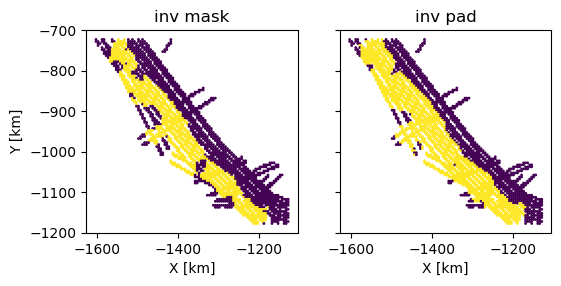

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(6,4), sharey=True)
ax = axs[0]
ax.scatter(x_grav/1000, y_grav/1000, c=grav_leveled.inv_msk, s=1)
ax.axis('scaled')
ax.set_title('inv mask')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax = axs[1]
ax.scatter(x_grav/1000, y_grav/1000, c=grav_leveled.inv_pad, s=1)
ax.axis('scaled')
ax.set_title('inv pad')
ax.set_xlabel('X [km]')
plt.show()